In [41]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import euclidean_distances
from math import sqrt

In [42]:
policemen = 'policemen.jpg'

def load_img(path):
    image = np.array(Image.open(path))
    return image, image.reshape(-1, image.shape[2])

def save_img(image, path):
    Image.fromarray(image).save(path)

In [43]:
image, X = load_img(policemen)
X.shape

(154401, 3)

In [56]:
def clusterize(X, k, interations, repeats):
    F_best, C_best = None, None
    np.random.seed(13)
    # repeat evaluation <repeats> times
    for r in range(repeats):
        # sample random centroids for init
        rand_idx  = np.random.choice(X.shape[0], k, replace=False)
        centroids = X[rand_idx]

        for _ in range(interations):
            # classify each point based on euclidean distances to current centroids
            distances = euclidean_distances(X, centroids)
            clusters = np.argmin(distances, axis=1)
            # recalculate centroids based on points classification
            old_centroids = np.copy(centroids)
            for cluster in np.unique(clusters):
                centroids[cluster] = np.mean(X[clusters == cluster], axis=0)
            
            # stop if centroids didn't change
            if (old_centroids == centroids).all():
                break

        # classify each point based on euclidean distances to best centroids for current repetition
        distances = euclidean_distances(X, centroids)
        clusters = np.argmin(distances, axis=1)
        # calculate functional for current prediction
        functional = distances[np.arange(X.shape[0]), clusters].mean()
        # update functional and points clusterization
        if F_best == None or functional < F_best:
            F_best = functional
            C_best = centroids
    
    # classify each point based on euclidean distances to best centroids 
    distances = euclidean_distances(X, C_best)
    clusters = np.argmin(distances, axis=1)
    return clusters, C_best

In [57]:
def draw(image, X, centroids, clusters):
    Y = np.zeros(X.shape, dtype=X.dtype)
    Y[np.arange(X.shape[0])] = centroids[clusters]
    image_clust = Y.reshape(image.shape)
    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
    ax[0].set_title('original')
    ax[0].imshow(image)
    ax[1].set_title('compressed')
    ax[1].imshow(image_clust)

---

## Внутренние критерии

### Davies-Bouldin

In [58]:
def var(centroid, points):
    sigma = np.sum(np.square(euclidean_distances(points, [centroid])))
    return np.sqrt(sigma / len(points))

def DB_ij(centr_i, centr_j, var_i, var_j):
    return (var_i + var_j) / euclidean(centr_i, centr_j)

def DB(centroids, clusters):
    k = len(centroids)
    db = np.zeros((k))
    for i in range(k):
        best_db = None
        for j in range(k):
            if i == j:
                continue
            centr_i, centr_j = centroids[i], centroids[j]
            points_i, points_j = X[clusters == i], X[clusters == j]
            var_i, var_j = var(centr_i, points_i), var(centr_j, points_j)
            db_ij = DB_ij(centr_i, centr_j, var_i, var_j)
            if best_db is None or best_db < db_ij:
                best_db = db_ij
        db[i] = best_db

    return db.mean()

In [94]:
iterations, repeats = 100, 1
ks = np.array([3, 4, 5, 6, 7, 8, 9])
db = np.zeros(ks.shape)
best_db = None
clusts, centrs = None, None
for i, k in enumerate(ks):
    clusters, centroids = clusterize(X, k, iterations, repeats)
    db[i] = DB(centroids, clusters)
    if best_db is None or best_db > db[i]:
        best_db = db[i]
        clusts, centrs = clusters, centroids
        
clusters, centroids = clusts, centrs

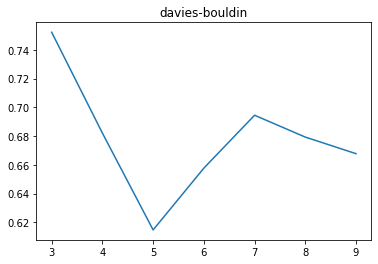

In [95]:
plt.title("davies-bouldin")
plt.plot(ks, db);

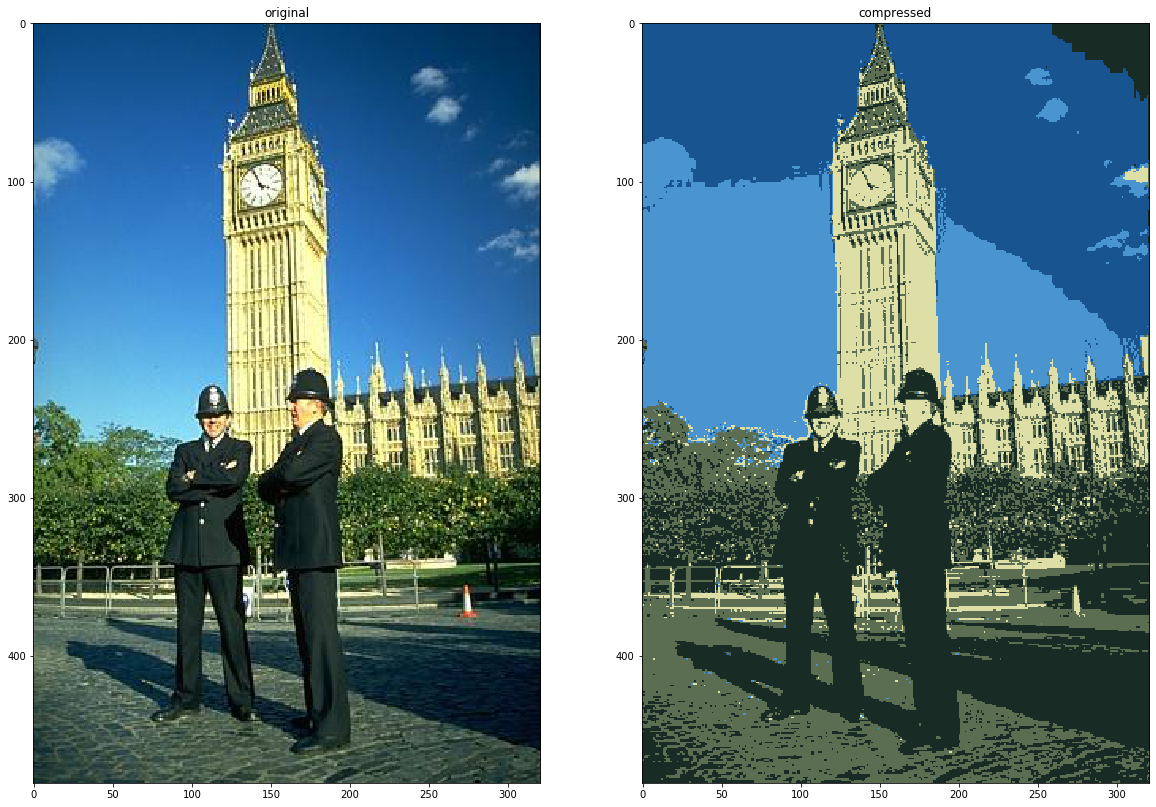

In [96]:
draw(image, X, centroids, clusters)

---

### Calinski-Harabasz

In [97]:
def CH(X, clusters, centroids):
    n, k = X.shape[0], len(centroids)
    sw, sb = 0., 0.
    mu = X.mean(axis=0)
    for i in range(k):
        cluster = X[clusters == i]
        centroid = np.mean(cluster, axis=0)
        sw += np.sum(np.square(cluster - centroid))
        sb += len(cluster) * np.sum(np.square(centroid - mu))
    return (sb * (n - k)) / (sw * (k - 1.))

In [98]:
ch = np.zeros(ks.shape)
for i, k in enumerate(ks):
    clusters, centroids = clusterize(X, k, iterations, repeats)
    ch[i] = CH(X, clusters, centroids)

In [99]:
delta = [ch[1] - 2*ch[0]] + [ch[i+1] - 2*ch[i] + ch[i-1] for i in range(1, len(ch)-1)] + [-2*ch[-2] + ch[-1]]

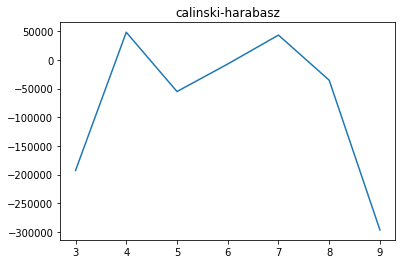

In [100]:
plt.title("calinski-harabasz")
plt.plot(ks, delta);

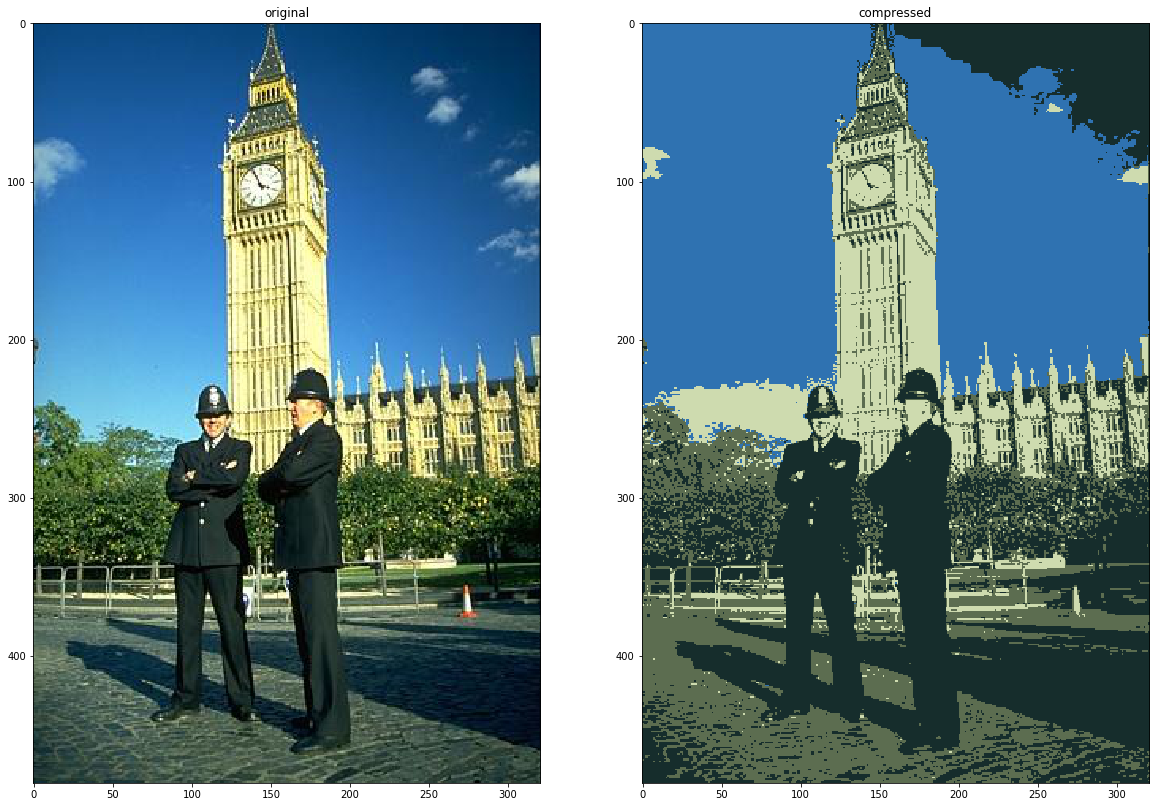

In [101]:
best_k = ks[np.argmin(delta[1:-1])]
clusters, centroids = clusterize(X, best_k, iterations, repeats)
draw(image, X, centroids, clusters)

---

## Внешние критерии

In [102]:
data = pd.read_csv("task_2_data_7.txt", sep=' ', names=['cluster','1','2'])

In [103]:
X = data[['1', '2']].values
Y = data['cluster'].values

In [104]:
ks = np.array([2, 3, 4, 5, 6])
tp, fn, fp, tn = np.zeros(ks.shape), np.zeros(ks.shape), np.zeros(ks.shape), np.zeros(ks.shape)
for idx, k in enumerate(ks):
    clusters, centroids = clusterize(X, k, iterations, repeats)
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            if i == j:
                continue
            if Y[i] == Y[j] and clusters[i] == clusters[j]:
                tp[idx] += 1
            elif Y[i] == Y[j] and clusters[i] != clusters[j]:
                fn[idx] += 1
            elif Y[i] != Y[j] and clusters[i] == clusters[j]:
                fp[idx] += 1
            elif Y[i] != Y[j] and clusters[i] != clusters[j]:
                tn[idx] += 1

ri = (tp + tn) / X.shape[0]**2
fm = tp / np.sqrt((tp + fn) * (tp + fp))

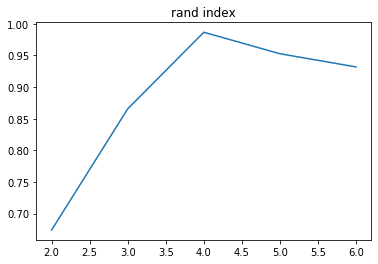

In [105]:
plt.title("rand index")
plt.plot(ks, ri);

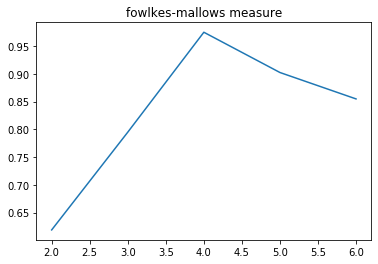

In [106]:
plt.title("fowlkes-mallows measure")
plt.plot(ks, fm);